## Import Necessary Libraries

In [ ]:
 # Import modules
import torch
import torch.nn as nn

## Explanation

Here, we are trying to build a Resnet-50 layer or greater. So, let's take a look at ResNet-50 layer.
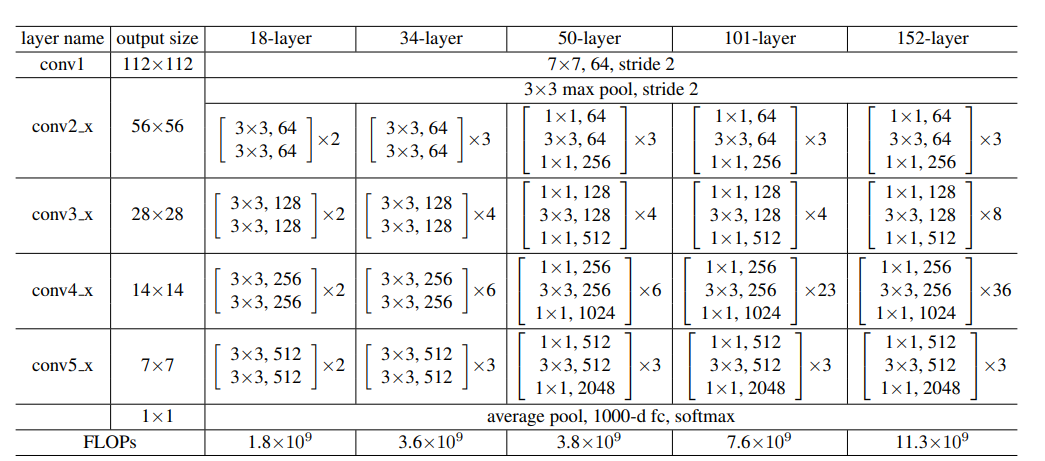

In every ResNet architecture, image input should be of shape `224 x 224, 3`.<br>

The image is now passed through the First convolution layer `conv1`.<br>
In `conv1`, the image passed through `7 x 7` convolution with 64 filters and stride of `2` followed by maxpooling with `3 x 3` filter and stride of `2`.

The resulting output is then of shape `112 x 112, 64`.

#### Residual Blocks

Now, we move to residual blocks.<br>
<br>
In the Second convolution, `conv2_x` we can see the following,<br>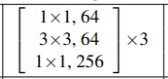



1.   First we pass the output from last layer that was of shape `112 x 112, 64` <br> to the first convolution in `conv2_x` followed by second and third respectively.
2.   After building a block and now we pass the skip connection from start to <br> end and the `x 3` represents that block is created 3 times and same for skip <br> connections.
3. This is the general trend in rest of the blocks too except for the different number of channels.


## Build a Residual Block

Let's start by building a Residual Block.<br>
<br>
We can see that first two layers in a block have same number of channels<br>
while the third convolution layer consists of 4 times the channel in first two layers.<br>
<br>
Time to build residual block.

In [ ]:
class Block(nn.Module):
  def __init__(self, num_layers, in_channels, out_channels, identity_downsample=None, stride=1):
      assert num_layers in [18, 34, 50, 101, 152], "should be a a valid architecture"
      super(Block, self).__init__()
      self.num_layers = num_layers
      if self.num_layers > 34:
          self.expansion = 4
      else:
          self.expansion = 1
      # ResNet50, 101, and 152 include additional layer of 1x1 kernels
      self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
      self.bn1 = nn.BatchNorm2d(out_channels)
      if self.num_layers > 34:
          self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1)
      else:
          # for ResNet18 and 34, connect input directly to (3x3) kernel (skip first (1x1))
          self.conv2 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
      self.bn2 = nn.BatchNorm2d(out_channels)
      self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion, kernel_size=1, stride=1, padding=0)
      self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)
      self.relu = nn.ReLU()
      self.identity_downsample = identity_downsample

  def forward(self, x):
      identity = x
      if self.num_layers > 34:
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
      x = self.conv2(x)
      x = self.bn2(x)
      x = self.relu(x)
      x = self.conv3(x)
      x = self.bn3(x)

      if self.identity_downsample is not None:
        identity = self.identity_downsample(identity)

      x += identity
      x = self.relu(x)
      return x

We are going to use the residual blocks multiple times.

## Building Resnet

In the class below, <br>


*   `block` represents the object created from the above class `Block`.
*   `layers` is the list of values that is used to define how many times a block is repeated <br> in a signle convolution block. i.e For ResNet-50 architecture, `layer = [3, 4, 6, 3]` <br>
(From the table above in Explanation section)



In [ ]:
class ResNet(nn.Module):
    def __init__(self, num_layers, block, image_channels, num_classes):
        assert num_layers in [18, 34, 50, 101, 152], f'ResNet{num_layers}: Unknown architecture! Number of layers has ' \
                                                     f'to be 18, 34, 50, 101, or 152 '
        super(ResNet, self).__init__()
        if num_layers < 50:
            self.expansion = 1
        else:
            self.expansion = 4
        if num_layers == 18:
            layers = [2, 2, 2, 2]
        elif num_layers == 34 or num_layers == 50:
            layers = [3, 4, 6, 3]
        elif num_layers == 101:
            layers = [3, 4, 23, 3]
        else:
            layers = [3, 8, 36, 3]
        self.in_channels = 64
        self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # ResNetLayers
        self.layer1 = self.make_layers(num_layers, block, layers[0], intermediate_channels=64, stride=1)
        self.layer2 = self.make_layers(num_layers, block, layers[1], intermediate_channels=128, stride=2)
        self.layer3 = self.make_layers(num_layers, block, layers[2], intermediate_channels=256, stride=2)
        self.layer4 = self.make_layers(num_layers, block, layers[3], intermediate_channels=512, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * self.expansion, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)
        return x

    def make_layers(self, num_layers, block, num_residual_blocks, intermediate_channels, stride):
        layers = []

        identity_downsample = nn.Sequential(nn.Conv2d(self.in_channels, intermediate_channels*self.expansion, kernel_size=1, stride=stride),
                                            nn.BatchNorm2d(intermediate_channels*self.expansion))
        layers.append(block(num_layers, self.in_channels, intermediate_channels, identity_downsample, stride))
        self.in_channels = intermediate_channels * self.expansion # 256
        for i in range(num_residual_blocks - 1):
            layers.append(block(num_layers, self.in_channels, intermediate_channels)) # 256 -> 64, 64*4 (256) again
        return nn.Sequential(*layers)

## Building Different variations of ResNet

In [ ]:
def ResNet34(img_channels=3, num_classes=1000):
    return ResNet(34, Block, img_channels, num_classes)


def ResNet50(img_channels=3, num_classes=1000):
    return ResNet(50, Block, img_channels, num_classes)


def ResNet101(img_channels=3, num_classes=1000):
    return ResNet(101, Block, img_channels, num_classes)


def ResNet152(img_channels=3, num_classes=1000):
    return ResNet(152, Block, img_channels, num_classes)

In [ ]:
net = ResNet50(img_channels=3, num_classes=1000)

In [ ]:
!pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Getting a summary of our model with torchinfo
from torchinfo import summary

summary(model = net,
        input_size = (4, 3, 224, 224),  # batch_size = (batch_size, color channels, height, width)
        col_names = ["input_size", "output_size", "num_params", "trainable"],
        col_width = 20,
        row_settings = ["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                                    [4, 3, 224, 224]     [4, 1000]            --                   True
├─Conv2d (conv1)                                   [4, 3, 224, 224]     [4, 64, 112, 112]    9,472                True
├─BatchNorm2d (bn1)                                [4, 64, 112, 112]    [4, 64, 112, 112]    128                  True
├─ReLU (relu)                                      [4, 64, 112, 112]    [4, 64, 112, 112]    --                   --
├─MaxPool2d (maxpool)                              [4, 64, 112, 112]    [4, 64, 56, 56]      --                   --
├─Sequential (layer1)                              [4, 64, 56, 56]      [4, 256, 56, 56]     --                   True
│    └─Block (0)                                   [4, 64, 56, 56]      [4, 256, 56, 56]     --                   True
│    │    └─Conv2d (conv1)                     

In [ ]:
net_100 = ResNet101(img_channels=3, num_classes=1000)

summary(model = net_100,
        input_size = (4, 3, 224, 224),  # batch_size = (batch_size, color channels, height, width)
        col_names = ["input_size", "output_size", "num_params", "trainable"],
        col_width = 20,
        row_settings = ["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                                    [4, 3, 224, 224]     [4, 1000]            --                   True
├─Conv2d (conv1)                                   [4, 3, 224, 224]     [4, 64, 112, 112]    9,472                True
├─BatchNorm2d (bn1)                                [4, 64, 112, 112]    [4, 64, 112, 112]    128                  True
├─ReLU (relu)                                      [4, 64, 112, 112]    [4, 64, 112, 112]    --                   --
├─MaxPool2d (maxpool)                              [4, 64, 112, 112]    [4, 64, 56, 56]      --                   --
├─Sequential (layer1)                              [4, 64, 56, 56]      [4, 256, 56, 56]     --                   True
│    └─Block (0)                                   [4, 64, 56, 56]      [4, 256, 56, 56]     --                   True
│    │    └─Conv2d (conv1)                     